**Growth of Artificial Intelligence in the Biological Sciences (2000-2025): Semi-Automated Searches in PubMed**

Library Installation

In [ ]:
!pip install biopython pandas wordcloud matplotlib numpy seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00


Add the necessary requirements to the NCBI database, to begin semantic analysis and graph generation

In [ ]:
from Bio import Entrez
import pandas as pd
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import re

**Search terms**

Provide your email to use the PubMed API. Create two lists with AI search terms and the biological search terms. Group them into a dictionary for easier searching.

In [ ]:
Entrez.email = "youremail@example.com"

ai_field = ["Artificial Intelligence", "Machine learning", "Deep learning"]
biofield = ["Biology", "Biomedicine", "Bioinformatics", "Genetics", "Ecology"]

dict_terms = {}
for i in biofield:
    dict_terms[i] = ai_field

print(dict_terms)

{'Biology': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Biomedicine': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Bioinformatics': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Genetics': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Ecology': ['Artificial Intelligence', 'Machine learning', 'Deep learning']}


**Function 1. Search strategy**

The function takes two terms (one from biology and one from AI), and searches PubMed articles containing both. The results are limited to a maximum of 500 articles published between 2000-2025, and the retrieved results are returned as a list of PMIDs.

Sources:

(1) Dennstädt et al. 2024

(2) Stack Overflow (2023)

In [ ]:
#Performs PubMed searches combining AI + biology terms found in [Title/Abstract]
def pubmed_data(terms, start_year="2000", end_year="2025", max_res=500):
  sugg = f""""{terms[0]}"[Title/Abstract] AND "{terms[1]}"[Title/Abstract] AND ({start_year}:{end_year}[dp])"""
  handle = Entrez.esearch(db="pubmed", term=sugg, retmax=max_res)
  results = Entrez.read(handle)
  handle.close()
  return results.get("IdList",[])

**Function 2. Text mining**

The *Entrez.efetch* module is used to retrive the full records for each PMID in the list "IdList". The data is stored in a dataframe that includes the requested metadata.


Source:

(3) TLDWTutorials. (2024)

In [ ]:
def details_rec(id_list, ai_term, bio_term):
    df = pd.DataFrame(columns=['PMID', 'Title', 'Abstract', 'Year', 'MeSH_Keywords', 'URL', 'Term_List','Bio_Term'])

    for pmid in id_list:
        try:
            handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
            docs = Entrez.read(handle)
            handle.close()

            for doc in docs['PubmedArticle']:
                paper = doc['MedlineCitation']['Article']

                title = paper['ArticleTitle']
                abstract = ' '.join(paper['Abstract']['AbstractText']) if 'Abstract' in paper and 'AbstractText' in paper['Abstract'] else 'Abstract not available'
                year = paper['Journal']['JournalIssue']['PubDate'].get('Year', 'No year found')
                #MeSH keywords
                keywords = ', '.join(keyword['DescriptorName'] for keyword in doc['MedlineCitation'].get ('MeshHeadingList', [])) or 'Keyword not found'

                url = f"https://www.ncbi.nlm.nih.gov/pubmed/{pmid}"

                pubmed_df=pd.DataFrame({
                    'PMID':[pmid],
                    'Title':[title],
                    'Abstract':[abstract],
                    'Year':[year],
                    'MeSH_Keywords': [keywords],
                    'URL': [url],
                    'Term_List': [ai_term],
                    'Bio_Term':[bio_term]})

                df = pd.concat([df,pubmed_df], ignore_index=True)

        except Exception as e:
            print(f"PMID error {pmid}: {e}")
            continue

        time.sleep(2)

    return df


**Data Processing**
Iterates through all AI-biology term combinations. Fetches article metadata for each pair, and stores the results in temporary dataframes, which are later concatenated into a single dataframe.


Source:

(4) Stack Overflow. (2015)

In [ ]:
all_results_df = []
for bioterm, termlist in dict_terms.items():
  for ai_term in termlist:
    id_list = pubmed_data([bioterm, ai_term], start_year="2000", end_year="2025")
    time.sleep(2) #Takes pauses between API requests
    #Store metadata for found articles
    df_result = details_rec(id_list, ai_term, bioterm)
    all_results_df.append(df_result)

if all_results_df:
    #Combine all temporary dataframes
    df_final = pd.concat(all_results_df, ignore_index=True)
    print(df_final)

    #This step calculate the total number of PMIDS found across all combinations
    pmid_count = len(df_final)

else:
    pmid_count=0
    print("No results found")
print(f"\nPMID found: {pmid_count}")

**Duplicates**

Removes duplicate PMID entries from 'df_final' dataframe.

In [ ]:
df_clean = df_final.drop_duplicates(subset=['PMID'])

**Keyword grouping**

A new column named *text_paper* is created, contains all the keywords found in text.
Separated lists are generated to store MeSH keywords and those from the [Title/Abstract].
'STOPWORDS' are added to filter out punctuation and semantically irrelevant words, and all terms are converted to lowercase.


Sources:

(5) Stack Overflow. (2012)

(6) W3Schools. (s.f.)

(7) Python Software Foundation. (s.f.)

(8) Kricka et al. (2021)

(2) Dennstädt et al. (2024)

(9) Stack Overflow (2020)

In [ ]:
#Create new column combining keywords found in [Title/Abstract]
df_clean['text_paper'] = df_clean['Title'] + ' ' + df_clean['Abstract']

#Empty list for MeSH keywords
mesh_kw = []
for keywords in df_clean['MeSH_Keywords']:
  if keywords != 'Keyword not found':
    #Clean blank spaces and convert text to lowercase
    words = [word.strip().lower() for word in keywords.split(',')]
    #'.extend()', adds all terms from 'words' list to 'mesh_kw'
    mesh_kw.extend(words)

stopwords=(["4", "two", "2","mi", "mrow","many", "3", "may", "best", "one", "well", "three", "will", "0", "1", "S","s","large","foundanimal", "founddeep","synthetickeyword","processingkeyword","learningkeyword", "personnelkeyword","foundkeyword","intelligencekeyword","proliferationkeyword", "foundhumans", "available", "keywords", "found","no", "not", "keyword"]) + list(STOPWORDS)

#Empty list for [Títle/Abstract] keywords
TiAb_kw = []
for text_p in df_clean['text_paper']:
  #Remove punctuation using 'regex' and convert text to lowercase
  text_p = text_p.lower()
  text_p = re.sub(r'[^\w\s]', ' ', text_p)
  words = text_p.split()
  #Extract and clean all words by removing blank spaces and stopwords, returns a list with relevant terms
  words = [word for word in words if word and word not in stopwords]
  TiAb_kw.extend(words)

#Combine both keyword lists
all_kwlist = mesh_kw +  TiAb_kw

**Keyword frequency count**

Through *Counter* module from *collections* library, the most common keywords are identified and analyzed.

Source:

(10) GeeksforGeeks. (2025)

In [ ]:
#Count keyword frequencies in "all_kwlist"
kw_counter = Counter(all_kwlist)

#Extract 77 top most frequent keywords
frequent_kw = kw_counter.most_common(77)
print("\nFrequent keywords:")
for keyword, frequency in frequent_kw:
  print(f"{keyword}: {frequency}")


Frequent keywords:
learning: 7140
data: 6358
based: 4205
machine: 3977
analysis: 3925
model: 3755
using: 3513
models: 3512
genes: 3069
deep: 2955
research: 2649
study: 2648
methods: 2641
protein: 2592
cell: 2586
ai: 2567
potential: 2458
disease: 2321
prediction: 2311
gene: 2305
cancer: 2213
artificial: 2169
clinical: 2144
genetic: 2118
intelligence: 2068
humans: 2054
high: 2023
used: 1981
molecular: 1784
development: 1713
biology: 1690
related: 1676
expression: 1675
network: 1674
new: 1617
algorithms: 1612
drug: 1592
accuracy: 1568
approaches: 1527
approach: 1519
bioinformatics: 1502
including: 1501
biomarkers: 1487
results: 1487
patients: 1446
identified: 1437
human: 1427
review: 1424
associated: 1405
biological: 1397
immune: 1384
information: 1336
performance: 1334
novel: 1332
studies: 1315
treatment: 1296
risk: 1283
features: 1266
identify: 1262
applications: 1252
use: 1235
datasets: 1229
key: 1221
computational: 1215
cells: 1214
method: 1199
understanding: 1193
significant: 1180
d

**Chart 1**

A barplot displaying the top 15 most frequent keywords from both MeSH and [Title/Abstract] terms.

Source:

(11) Stack Overflow. (2022)

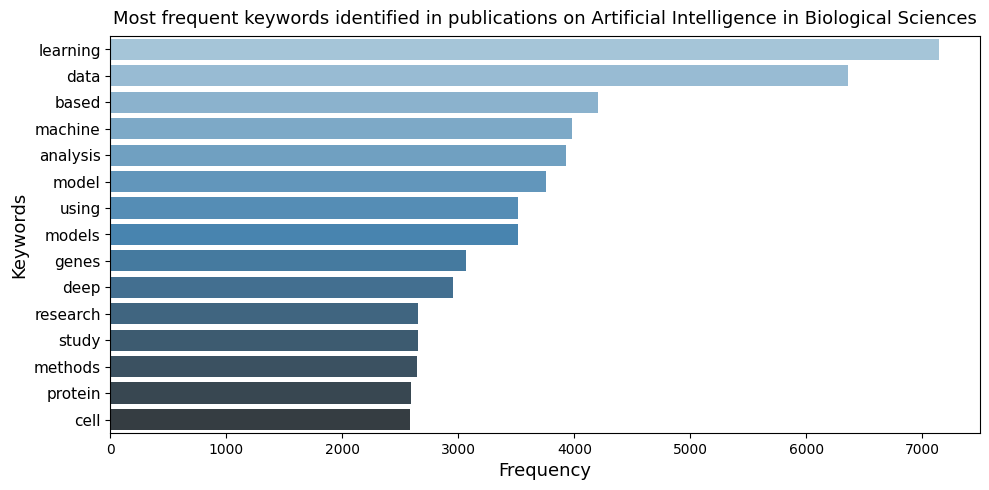

In [ ]:
plt.figure(figsize=(10, 5))
#Extract top 15 keywords and their frequencies
keywords = [keyword for keyword, _ in frequent_kw[:15]]
frequencies = [frequency for _, frequency in frequent_kw[:15]]

sns.barplot(x=frequencies, y=keywords, palette='Blues_d', hue=keywords, legend=False)

plt.title('Most frequent keywords identified in publications on Artificial Intelligence in Biological Sciences', fontsize=13, y=1.01)
plt.xlabel('Frequency', fontsize=13)
plt.xticks(fontsize=10)
plt.ylabel('Keywords', fontsize=13)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig('common_keywords.png', dpi=300)

plt.show()

**Create a keyword dictionary**

WordCloud library cannot interpret the tuple structure of 'frequent_kw', so a dictionary is created to store the data as key-value pairs.

In [ ]:
kw_dict = dict(frequent_kw)

**Chart 2. Create a Wordcloud**

Using *.generate_from_frequencies()*, the keyword dictionary is added, allowing the frequency of the terms to be visualized.

Sources:

(12)  Mueller. (2020)

(13) Mueller. (2020)

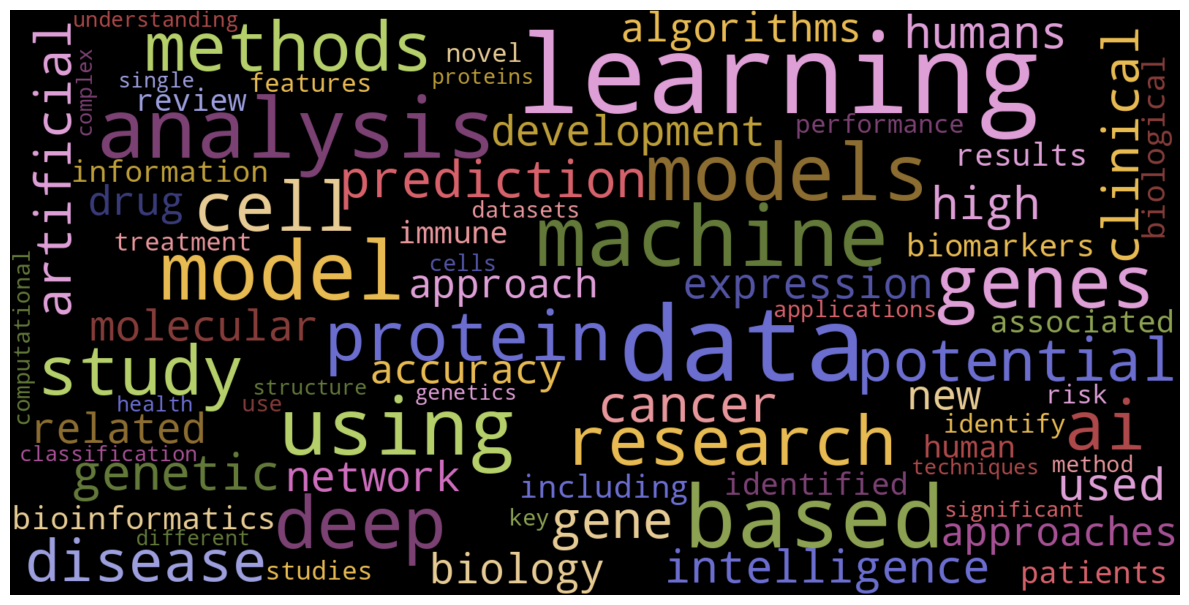

In [ ]:
wordcloud_freq = WordCloud(max_words=100, stopwords=stopwords, width=1600, height=800, background_color="black", max_font_size=150).generate_from_frequencies(kw_dict)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_freq.recolor(colormap='tab20b'),interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1.08)
plt.savefig('wordcloud_freq.png', dpi=300)
plt.show()

**Data conversion**

This step converts the 'Years' column from string to numeric format, allowing the distribution of publications over time to be plotted. Also, AI-related terms are changed to string for consistent text processing.

Sources:

(14) Stack Overflow. (2020)

(15) GeeksforGeeks. (2024)

In [ ]:
#Convert 'Year' column to numeric and filter for 2000-2025 range
df_clean['Year']=pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2025)]

#Analyze publication distribution by year
year_distribution=df_clean.groupby(["Year"]).size()
print("Distribution:")
print(year_distribution)

#In a new dF, the data is grouped by the AI-biology search terms, and the numer of ocurrences for each term is counted.
df_clean['Term_List']=df_clean['Term_List'].astype(str)
df_bar = df_clean.groupby(['Bio_Term', 'Term_List']).size().reset_index(name='Count')

print(df_clean)

Distribution:
Year
2004.0       3
2006.0       3
2007.0       3
2008.0       3
2009.0       7
2010.0       7
2011.0       8
2012.0       5
2013.0       7
2014.0       9
2015.0      16
2016.0      24
2017.0      27
2018.0      55
2019.0     101
2020.0     137
2021.0     256
2022.0     438
2023.0     702
2024.0    1436
2025.0    1411
dtype: int64
          PMID                                              Title  \
0     40366503  Research on the developments of artificial int...   
1     40364863  In Silico Research Is Rewriting the Rules of D...   
2     40364668     Shining a Light on the Future of Biophotonics.   
3     40364189  Beyond Size: Advanced MRI Breakthroughs in Pre...   
4     40361907  From Morphology to Gene Expression Profiling i...   
...        ...                                                ...   
4655  33466513  Mask R-CNN and OBIA Fusion Improves the Segmen...   
4656  32620873  A new method to control error rates in automat...   
4657  31970895  Neural hierarchi

<ipython-input-13-1348173718>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Term_List']=df_clean['Term_List'].astype(str)


**Chart 3. Publication count. AI vs biological fields**

Visualizes the total publications per AI-biology term combination from 'df_bar', showing research trends across specified field pairings.

Sources:

(16) Python Graph Gallery. (2024)

(17) Laiq, F. (2024)

(18) Modin Project. (2019)

(19) Mulina, V. (2023)

(20)Waskom, M. (2023)

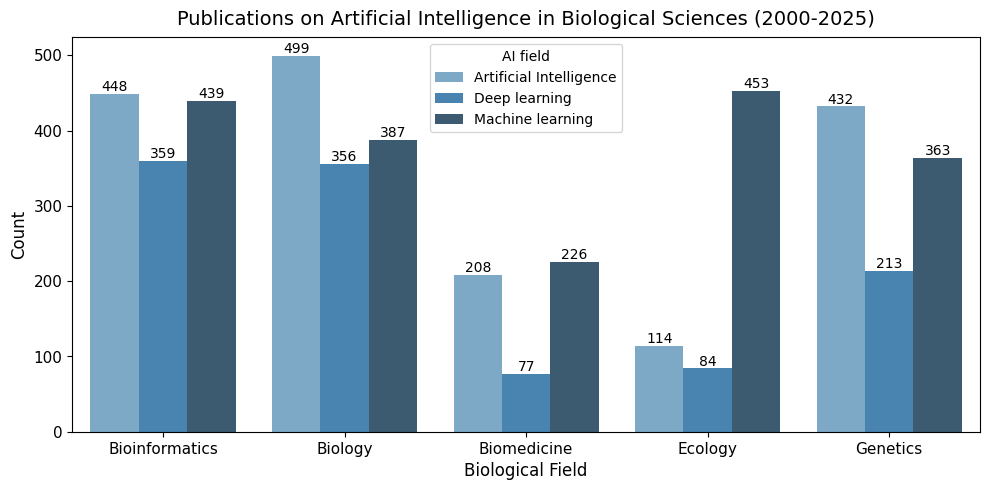

In [ ]:
plt.figure(figsize=(10, 5))
#Create grouped barplot showing publications counts per field combination
ax=sns.barplot(x='Bio_Term', y='Count', hue='Term_List', data=df_bar, palette='Blues_d')

plt.title('Publications on Artificial Intelligence in Biological Sciences (2000-2025)', fontsize=14, y= 1.01)
plt.xlabel('Biological Field', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='AI field', fontsize=10)


#Add vule labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.savefig('barplot_count.png', dpi=300)
plt.show()

**Chart 4. AI adoption in biogical sciences (2000-2025)**

Tracks the growing implementation of AI in biological fields through analysis of publication mentions

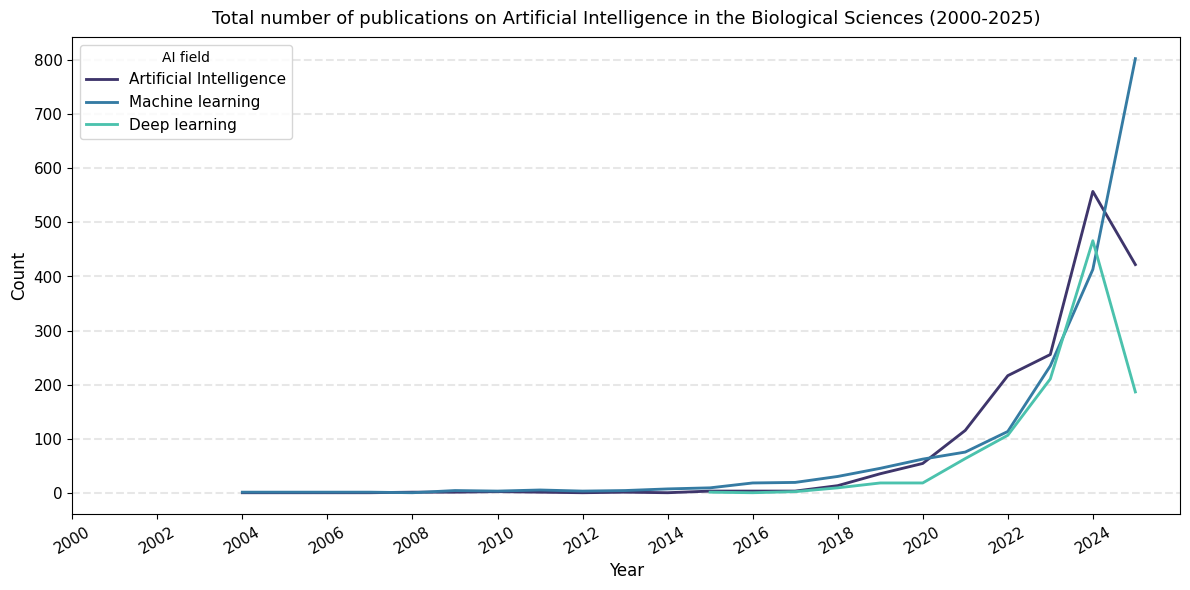

In [ ]:
#Groups data publications by year and AI subfield
summary_df = df_clean.groupby(['Year', 'Term_List']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Count', hue='Term_List', data=summary_df, linewidth=2.05, palette='mako')

plt.title("Total number of publications on Artificial Intelligence in the Biological Sciences (2000-2025)", fontsize=13, y= 1.01)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(2000,2026, 2), rotation=30, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=1.5, axis='y')

plt.legend(title='AI field', fontsize=11)

plt.tight_layout()
plt.savefig("total_pub", dpi=300)
plt.show()

References

(1) Dennstädt, F., Zink, J., Putora, P. M., Hastings, J., & Cihoric, N. (2024). Title and abstract screening for literature reviews using large language models: an exploratory study in the biomedical domain. Systematic Reviews, 13(1). https://doi.org/10.1186/s13643-024-02575-4

(2) Stack Overflow (2023). *Biopython: How can I increase the number found using Entrez.esearch?* https://stackoverflow.com/questions/75933779/biopython-how-can-i-increase-the-number-of-articles-found-using-entrez-esearch

(3) TLDWTutorials. (2024). PubMed Data Extraction Script. GitHub. https://github.com/TLDWTutorials/PubmedAPI/tree/main

(4) Stack Overflow. *Appending pandas dataframes generated in a for loop*. (2015). https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

(5) Stack Overflow. (2012). *String concatenation of two pandas columns*. https://stackoverflow.com/questions/11858472/string-concatenation-of-two-pandas-columns

(6)W3Schools. (s.f.). *Python RegEx*. https://www.w3schools.com/python/python_regex.asp

(7) Python Software Foundation. (s.f.). *re-Regular expression operations*. Recuperado el 22 de abril  de 2025. https://docs.python.org/3/library/re.html

(8) Kricka, L. J., Cornish, T. C., & Park, J. Y. (2021). Eponyms in clinical chemistry. Clinica Chimica Acta, 512, 28–32. https://doi.org/10.1016/j.cca.2020.11.014

(9) Stack Overflow (2020). *How to fund specific words in a text and count them using Python?. https://stackoverflow.com/questions/63666138/how-to-find-specific-words-in-a-text-and-count-them-using-python

(10) GeeksforGeeks. (2025). *Python most_common() Function*. https://www.geeksforgeeks.org/python-most_common-function/

(11) Stack Overflow. (2022). *Unpack the first two elements in list/tuple*. https://stackoverflow.com/questions/11371204/unpack-the-first-two-elements-in-list-tuple

(12)  Mueller. (2020). *wordcloud.WordCoud*. https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

(13) Mueller. (2020). *Using frequency*. https://amueller.github.io/word_cloud/auto_examples/frequency.html

(14) Stack Overflow. (2020). *How do I transform a pandas groupby with a condition on the transformation?*. https://stackoverflow.com/questions/61815267/how-do-i-transform-a-pandas-groupby-with-a-condition-on-the-transformation

(15) GeeksforGeeks. (2024). *Pandas dataframe.groupby() Method*. https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/

(16) Python Graph Gallery. (2024). *Basic Barplot using Seaborn*. https://python-graph-gallery.com/basic-barplot-with-seaborn/

(17) Laiq, F. (2024). *Filtrar filas que contienen una cadena específica en Pandas*. https://www.delftstack.com/es/howto/python-pandas/pandas-column-contains-string/?utm_source=chatgpt.com

(18) Modin Project. (2019).*Issue #847. Plotting with seaborn*. https://github.com/modin-project/modin/issues/847

(19) Mulina, V. (2023). *Bank Customers Categorization - Clustering*. https://www.kaggle.com/code/valeriamulina/bank-customers-categorization-clustering?scriptVersionId=

(20) Waskom, M. (2023). *Issue #3568. Feature request: allow seaborn to annotate a subplot with 0 counts, when there are 0 counts for all bars in a subplot*. https://github.com/mwaskom/seaborn/issues/3568
